# Problem Category

Binary Classification

# Data Loading

In [2]:
import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
%matplotlib inline
import math
from sklearn.metrics import *

## Reading Training and Test Data

In [3]:
input_1 = pd.read_csv('/kaggle/competition/BIX/train_data.csv')
test = pd.read_csv('/kaggle/competition/BIX/test_data.csv')

# Shuffle training data 
train = input_1.copy().sample(frac=1)
train.head(5)

,radius_0,texture_0,perimeter_0,radius_1,texture_1,perimeter_1,radius_2,texture_2,perimeter_2,age,treatment_date,diagnose_date,cancer_type
16,12.986264,21.463125,79.254473,13.327439,8.981956,99.308755,13.728816,28.5635025334,44.918942,36,2000-04-18,2005-03-13,0
273,8.454467,7.729734,66.286724,9.394476,21.087932,53.046225,10.946111,xx,76.596414,32,2007-02-13,2003-11-20,1
197,10.590598,16.687162,69.681129,NaN,41.344835,67.742404,10.868533,21.0020466931,57.174787,23,2005-04-16,2003-09-23,1
204,13.663531,15.282935,82.906412,14.453111,48.176517,88.578308,13.527569,17.337022622,97.863396,33,2004-09-15,2003-05-05,1
106,14.085689,21.359689,91.396123,15.461898,3.349190,NaN,14.708694,19.2399913819,118.577848,61,2006-09-15,2007-07-08,0


Shuffling training data is always a good practice

In [4]:
test.head(5)

,radius_0,texture_0,perimeter_0,radius_1,texture_1,perimeter_1,radius_2,texture_2,perimeter_2,age,treatment_date,diagnose_date
0,12.567724,13.561447,77.106898,10.773643,45.494416,NaN,12.526989,15.7063580493,123.583682,31,2008-11-19,2003-04-22
1,11.195949,19.693575,81.244301,15.058411,7.909249,86.766622,13.728960,21.485344712,154.164201,18,2001-08-18,2003-07-07
2,15.712720,26.114134,90.977022,13.832857,18.086143,NaN,14.758324,27.0205254475,114.023403,43,2006-11-17,2004-03-06
3,13.428698,26.649458,76.456016,14.837875,6.122950,89.609565,16.279206,29.1837924649,199.756098,57,2001-01-10,2006-02-24
4,179.763472,14.175435,51.125047,NaN,21.116416,52.041704,9.191477,13.5857306814,74.879232,26,2008-07-12,2004-06-21


# Data Exploration

## Data Dictionary

In [5]:
print('Total instances in train: ' + str(len(train)))
print('Total instances in test: ' + str(len(test)))
print('Total null values in train: ' + str(train.isnull().sum().sum()))
print('Total null values in test: ' + str(test.isnull().sum().sum()))
print('Attributes Count  in train: ' + str(len(list(train.columns.values))))
print('Attributes Count  in test: ' + str(len(list(test.columns.values))))
print()
print('Attributes Data Types  in train:')
print()
print(train.dtypes)

Total instances in train: 398
Total instances in test: 171
Total null values in train: 189
Total null values in test: 91
Attributes Count  in train: 13
Attributes Count  in test: 12

Attributes Data Types  in train:

radius_0          float64
texture_0         float64
perimeter_0       float64
radius_1          float64
texture_1         float64
perimeter_1       float64
radius_2          float64
texture_2          object
perimeter_2       float64
age                 int64
treatment_date     object
diagnose_date      object
cancer_type         int64
dtype: object


Why texture_2 is object type? Something is wierd here. By look at larger sample of data, I come to a conclusion that some values ('xx') need replacement. 

## Data Types Adjustments

In [66]:
train['texture_2'] = train['texture_2'].apply(lambda x : 'NaN' if x == 'xx' else x)
train['texture_2'] = train['texture_2'].astype('float')
train['cancer_type'] = train['cancer_type'].astype('object')

print(train.dtypes)
print()
print('Total null values: ' + str(train.isnull().sum().sum()))


# Same transformations for test data

test['texture_2'] = test['texture_2'].apply(lambda x : 'NaN' if x == 'xx' else x)
test['texture_2'] = test['texture_2'].astype('float')

radius_0          float64
texture_0         float64
perimeter_0       float64
radius_1          float64
texture_1         float64
perimeter_1       float64
radius_2          float64
texture_2         float64
perimeter_2       float64
age                 int64
treatment_date     object
diagnose_date      object
cancer_type        object
dtype: object

Total null values: 0


Applying transformation on training as well as testing data for keeping both data in sync so that no explosions during prediction stage. 
Train > Feature Vectors > Model (Training)
Test > Feature Vectors > Model (Prediction)

In [67]:
# train.to_csv('/kaggle/competition/BIX/trsin_clean.csv', index=False, header=True)

## Features Segments [Nominal / Numeric / Target]

In [7]:
nominalAttributes = ['treatment_date', 'diagnose_date']
print(nominalAttributes)
numericAttributes = list(set(train.columns.values)-set(nominalAttributes)-set(['cancer_type']))
print(numericAttributes)
targetAttribute = ['cancer_type']
print(targetAttribute)

['treatment_date', 'diagnose_date']
['perimeter_2', 'radius_0', 'radius_1', 'age', 'texture_0', 'perimeter_0', 'perimeter_1', 'texture_2', 'texture_1', 'radius_2']
['cancer_type']


## Features Values/NaN/Unique Counts 

In [8]:
print(train.count())
print()
count_nan = len(train) - train.count()
print(count_nan)
print()
for col in list(train.columns.values):
    unique = train[col].nunique()
    print(col + ' has unique values: '+ str(unique))
    if unique < 20:
        print(set(train[col]))

radius_0          398
texture_0         398
perimeter_0       398
radius_1          343
texture_1         398
perimeter_1       264
radius_2          398
texture_2         382
perimeter_2       398
age               398
treatment_date    398
diagnose_date     398
cancer_type       398
dtype: int64

radius_0            0
texture_0           0
perimeter_0         0
radius_1           55
texture_1           0
perimeter_1       134
radius_2            0
texture_2          16
perimeter_2         0
age                 0
treatment_date      0
diagnose_date       0
cancer_type         0
dtype: int64

radius_0 has unique values: 398
texture_0 has unique values: 398
perimeter_0 has unique values: 398
radius_1 has unique values: 343
texture_1 has unique values: 398
perimeter_1 has unique values: 264
radius_2 has unique values: 398
texture_2 has unique values: 382
perimeter_2 has unique values: 398
age has unique values: 47
treatment_date has unique values: 371
diagnose_date has unique values: 352

NaN attributes radius_1, perimeter_1 and texture_2. perimeter_1 will be used in regression task :(

## Describe Numeric Features 

In [9]:
train.describe()

,radius_0,texture_0,perimeter_0,radius_1,texture_1,perimeter_1,radius_2,texture_2,perimeter_2,age
count,398.000000,398.000000,398.000000,343.000000,398.000000,264.000000,398.000000,382.000000,398.000000,398.000000
mean,21.303711,18.957554,92.128890,14.123575,30.417222,94.086379,14.134922,19.459098,127.222422,39.876884
std,49.987646,6.243499,25.159787,3.780636,15.027855,27.314466,3.748146,5.802189,49.097558,13.427196
min,6.401956,-17.243202,45.612505,5.752395,2.395868,43.444930,7.079847,-0.966998,44.918942,18.000000
25%,11.693885,14.581364,74.975361,11.600838,19.898062,75.188880,11.573592,15.456557,84.123724,28.000000
50%,13.468170,18.238742,87.376764,13.385789,30.897762,90.054613,13.333610,19.436094,129.992697,39.000000
75%,16.323024,22.494291,104.876420,16.051640,42.555657,106.085670,16.093900,22.944174,169.538170,50.000000
max,561.311068,40.064462,193.755763,29.645166,55.820612,227.162938,28.563252,39.331864,214.192377,64.000000


Golden nuggets will be possibly used for missing value predictions strategy decision.

## Describe Nominal Features

In [10]:
train.describe(include=['O'])

,treatment_date,diagnose_date,cancer_type
count,398,398,398
unique,371,352,2
top,2003-04-27,2005-04-01,1
freq,3,3,250


# Data Visualizations

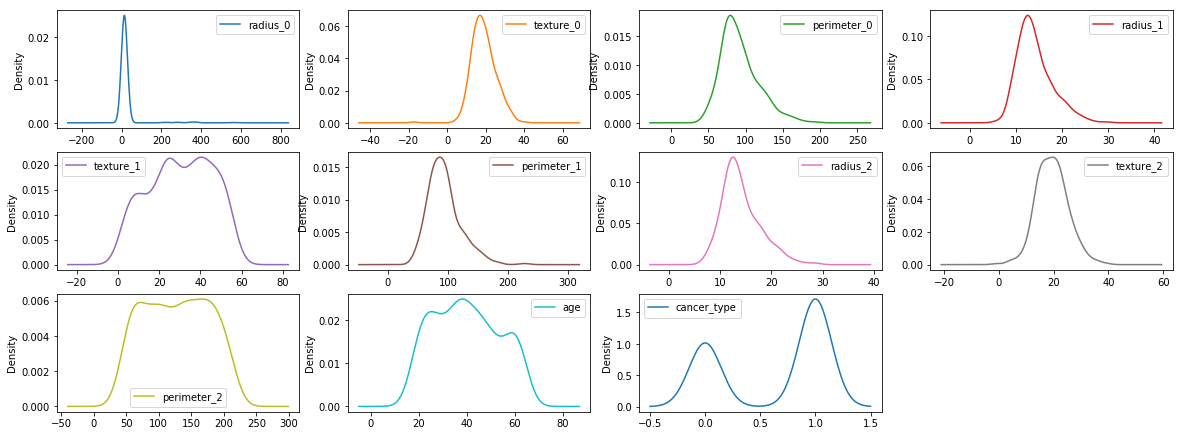

In [11]:
# Training Data
%matplotlib inline
train.plot(kind='density', subplots=True, layout=(4,4), legend=True, figsize=(20, 10), sharex=False)
plt.show()

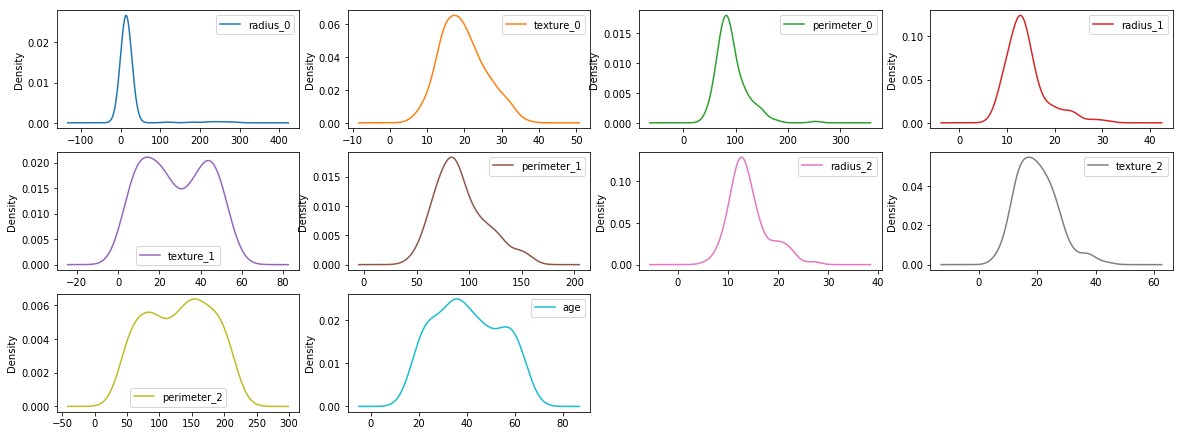

In [12]:
# Test Data
%matplotlib inline
test.plot(kind='density', subplots=True, layout=(4,4), legend=True, figsize=(20, 10), sharex=False)
plt.show()

Looking at trainig data just for curiosity. 

## Data Imputation with Average 

In [13]:
print('NaN before imputation in train '+ str(train.isnull().values.any()))
train['radius_1'] = train['radius_1'].fillna(train['radius_1'].mean())
train['texture_2'] = train['texture_2'].fillna(train['texture_2'].mean())
train['perimeter_1'] = train['perimeter_1'].fillna(train['perimeter_1'].mean())

#train['radius_1'] = train['radius_1'].fillna(0)
#train['texture_2'] = train['texture_2'].fillna(0)
#train['perimeter_1'] = train['perimeter_1'].fillna(0)
print('NaN after imputation in train '+ str(train.isnull().values.any()))

# Transform also test data (Using mean values of training)

print('NaN before imputation in test '+ str(test.isnull().values.any()))
test['radius_1'] = test['radius_1'].fillna(train['radius_1'].mean())
test['texture_2'] = test['texture_2'].fillna(train['texture_2'].mean())
test['perimeter_1'] = test['perimeter_1'].fillna(train['perimeter_1'].mean())
print('NaN after imputation in train '+ str(test.isnull().values.any()))

NaN before imputation in train True
NaN after imputation in train False
NaN before imputation in test True
NaN after imputation in train False


Other possible strategies may use some model based interpolation but I would avoid using such for a model specially for perimeter_1 since 34% values are missing on such a small dataset. I would also avoid replacing zero since it spoils the density plot with much severity.

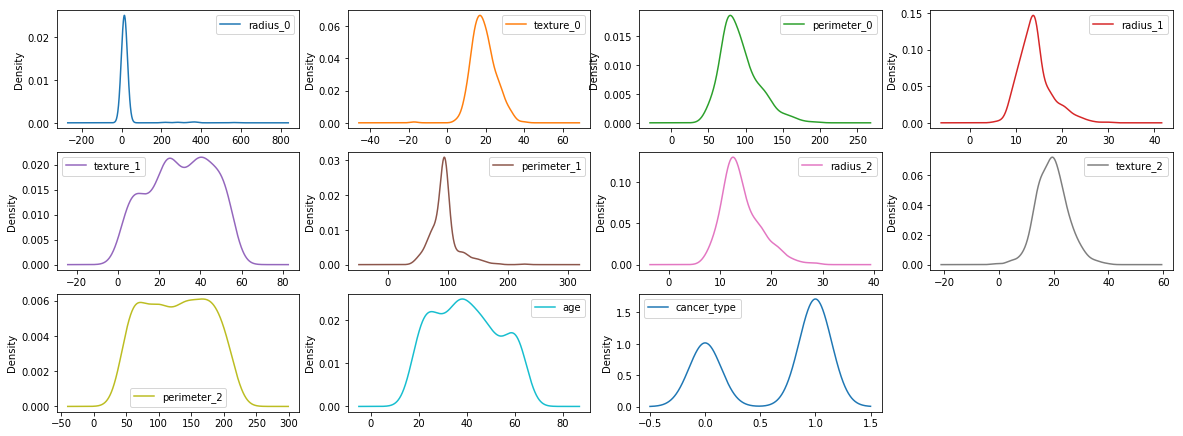

In [14]:
%matplotlib inline
train.plot(kind='density', subplots=True, layout=(4,4), legend=True, figsize=(20, 10), sharex=False)
plt.show()

Dessity plots after replacing NaN with mean. Not much difference as compared to density plot before.

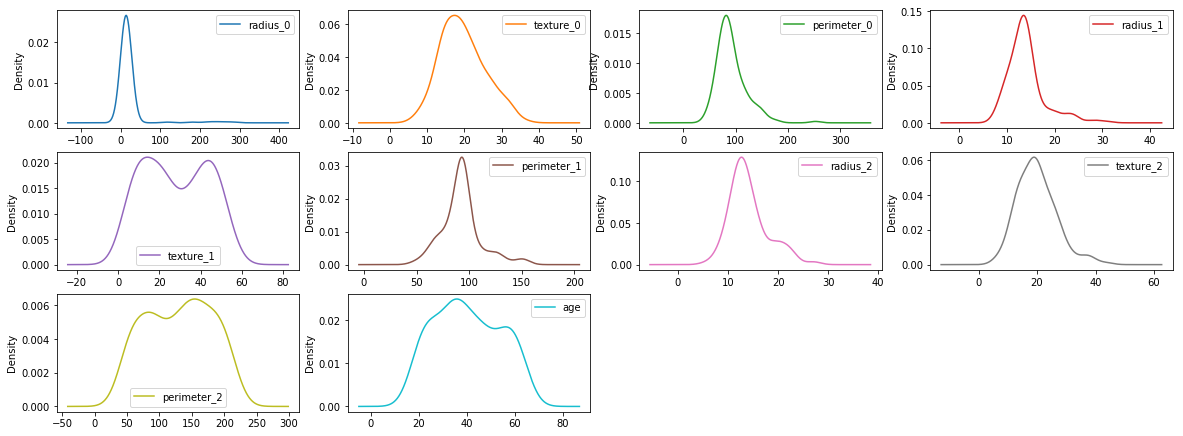

In [15]:
%matplotlib inline
test.plot(kind='density', subplots=True, layout=(4,4), legend=True, figsize=(20, 10), sharex=False)
plt.show()

## Target Feature Histogram 

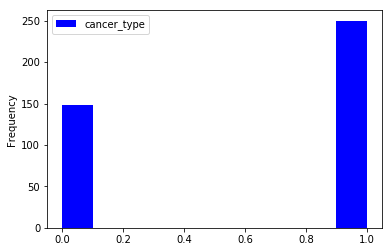

In [16]:
train[targetAttribute].plot(kind='hist', color=['blue']);

One of the first steps towards modeling. Bias in training samples. In real world data bias is much larger and it is required to use some balancing approaches e.g. SMOTE etc for sythetic samples generation for minor class. Here I will not use such technique but it may be possible that minor class contributes much to model's error since model have relatively few samples to learn. 

## Numeric Feature Stats 

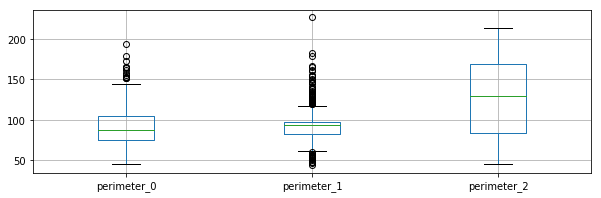

In [17]:
%matplotlib inline
features_1 = ['perimeter_0','perimeter_1','perimeter_2']
features_2 = set(train.columns.values)-set(features_1);
train[features_1].boxplot(figsize=(10, 3));

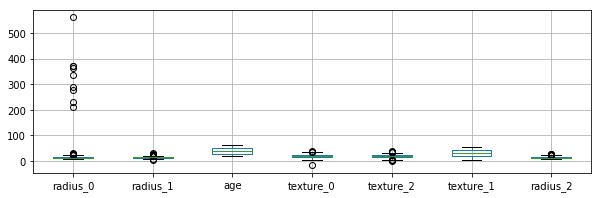

In [18]:
%matplotlib inline
train[list(features_2)].boxplot(figsize=(10, 3));

Huge upper outliers in radius_0 and also perimeter_1 contains some upper outliers but perimeter_0 contains both upper and lower outliers. Due to smaller data, deleting outliers/ignoring features is not feasible. The two possible stratigies are either I take Log Tranform to punish upper outliers. The 2nd is creating bins for data/outliers based on statistical outlier (Q3 + 2*IQR < outlier < Q1 - 2*IQR ) and let the model learn figure it out itself using outlier bins. I will use the 2nd strategy.

For more reference see https://i.stack.imgur.com/ZN8N6.png

##  Numeric Feature Stats By Target

0         AxesSubplot(0.1,0.15;0.363636x0.75)
1    AxesSubplot(0.536364,0.15;0.363636x0.75)
dtype: object

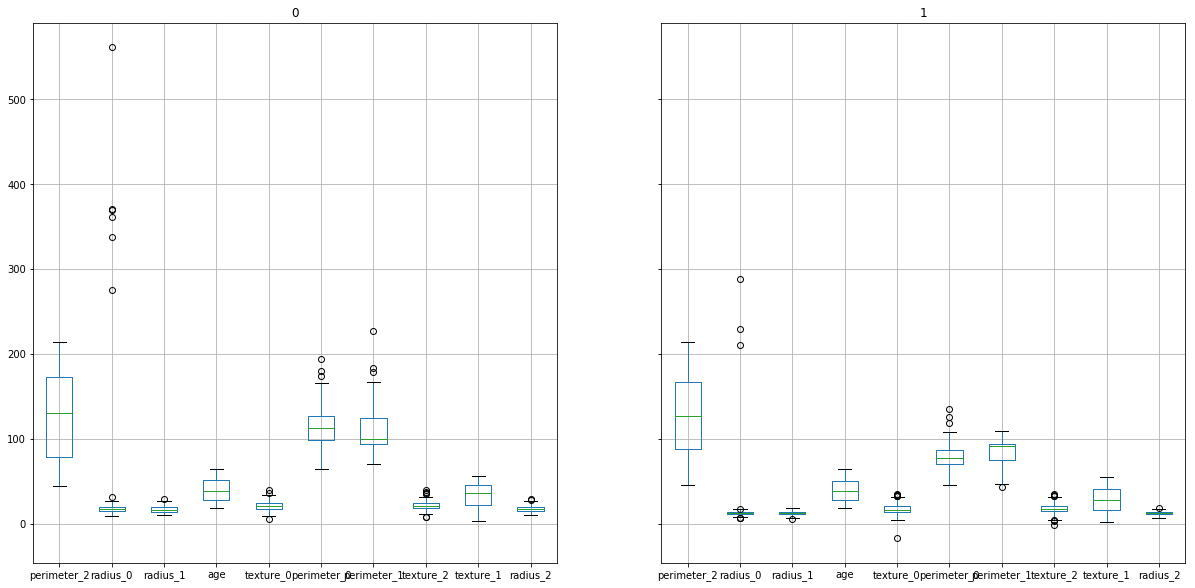

In [25]:
grouped = train[numericAttributes+targetAttribute].groupby(by= targetAttribute)
grouped.boxplot(figsize=(20, 10))

Outliers of radius_0 are much worse across class 0. Perimeter_0 and perimeter_1 boxplot is higher for class 0.

In [26]:
# Can be meaningful during data imputation stage
meanNumeric = train[targetAttribute+numericAttributes].groupby(targetAttribute).mean()
meanNumeric

,perimeter_2,radius_0,radius_1,age,texture_0,perimeter_0,perimeter_1,texture_2,texture_1,radius_2
cancer_type,,,,,,,,,,
0,126.390394,32.050121,16.983712,39.905405,21.084027,115.086256,110.322115,21.657759,33.500849,17.419721
1,127.714982,14.941836,12.430374,39.860000,17.698682,78.538130,84.474822,18.157490,28.591715,12.190320


## Numeric Feature Scatter Plot By Target

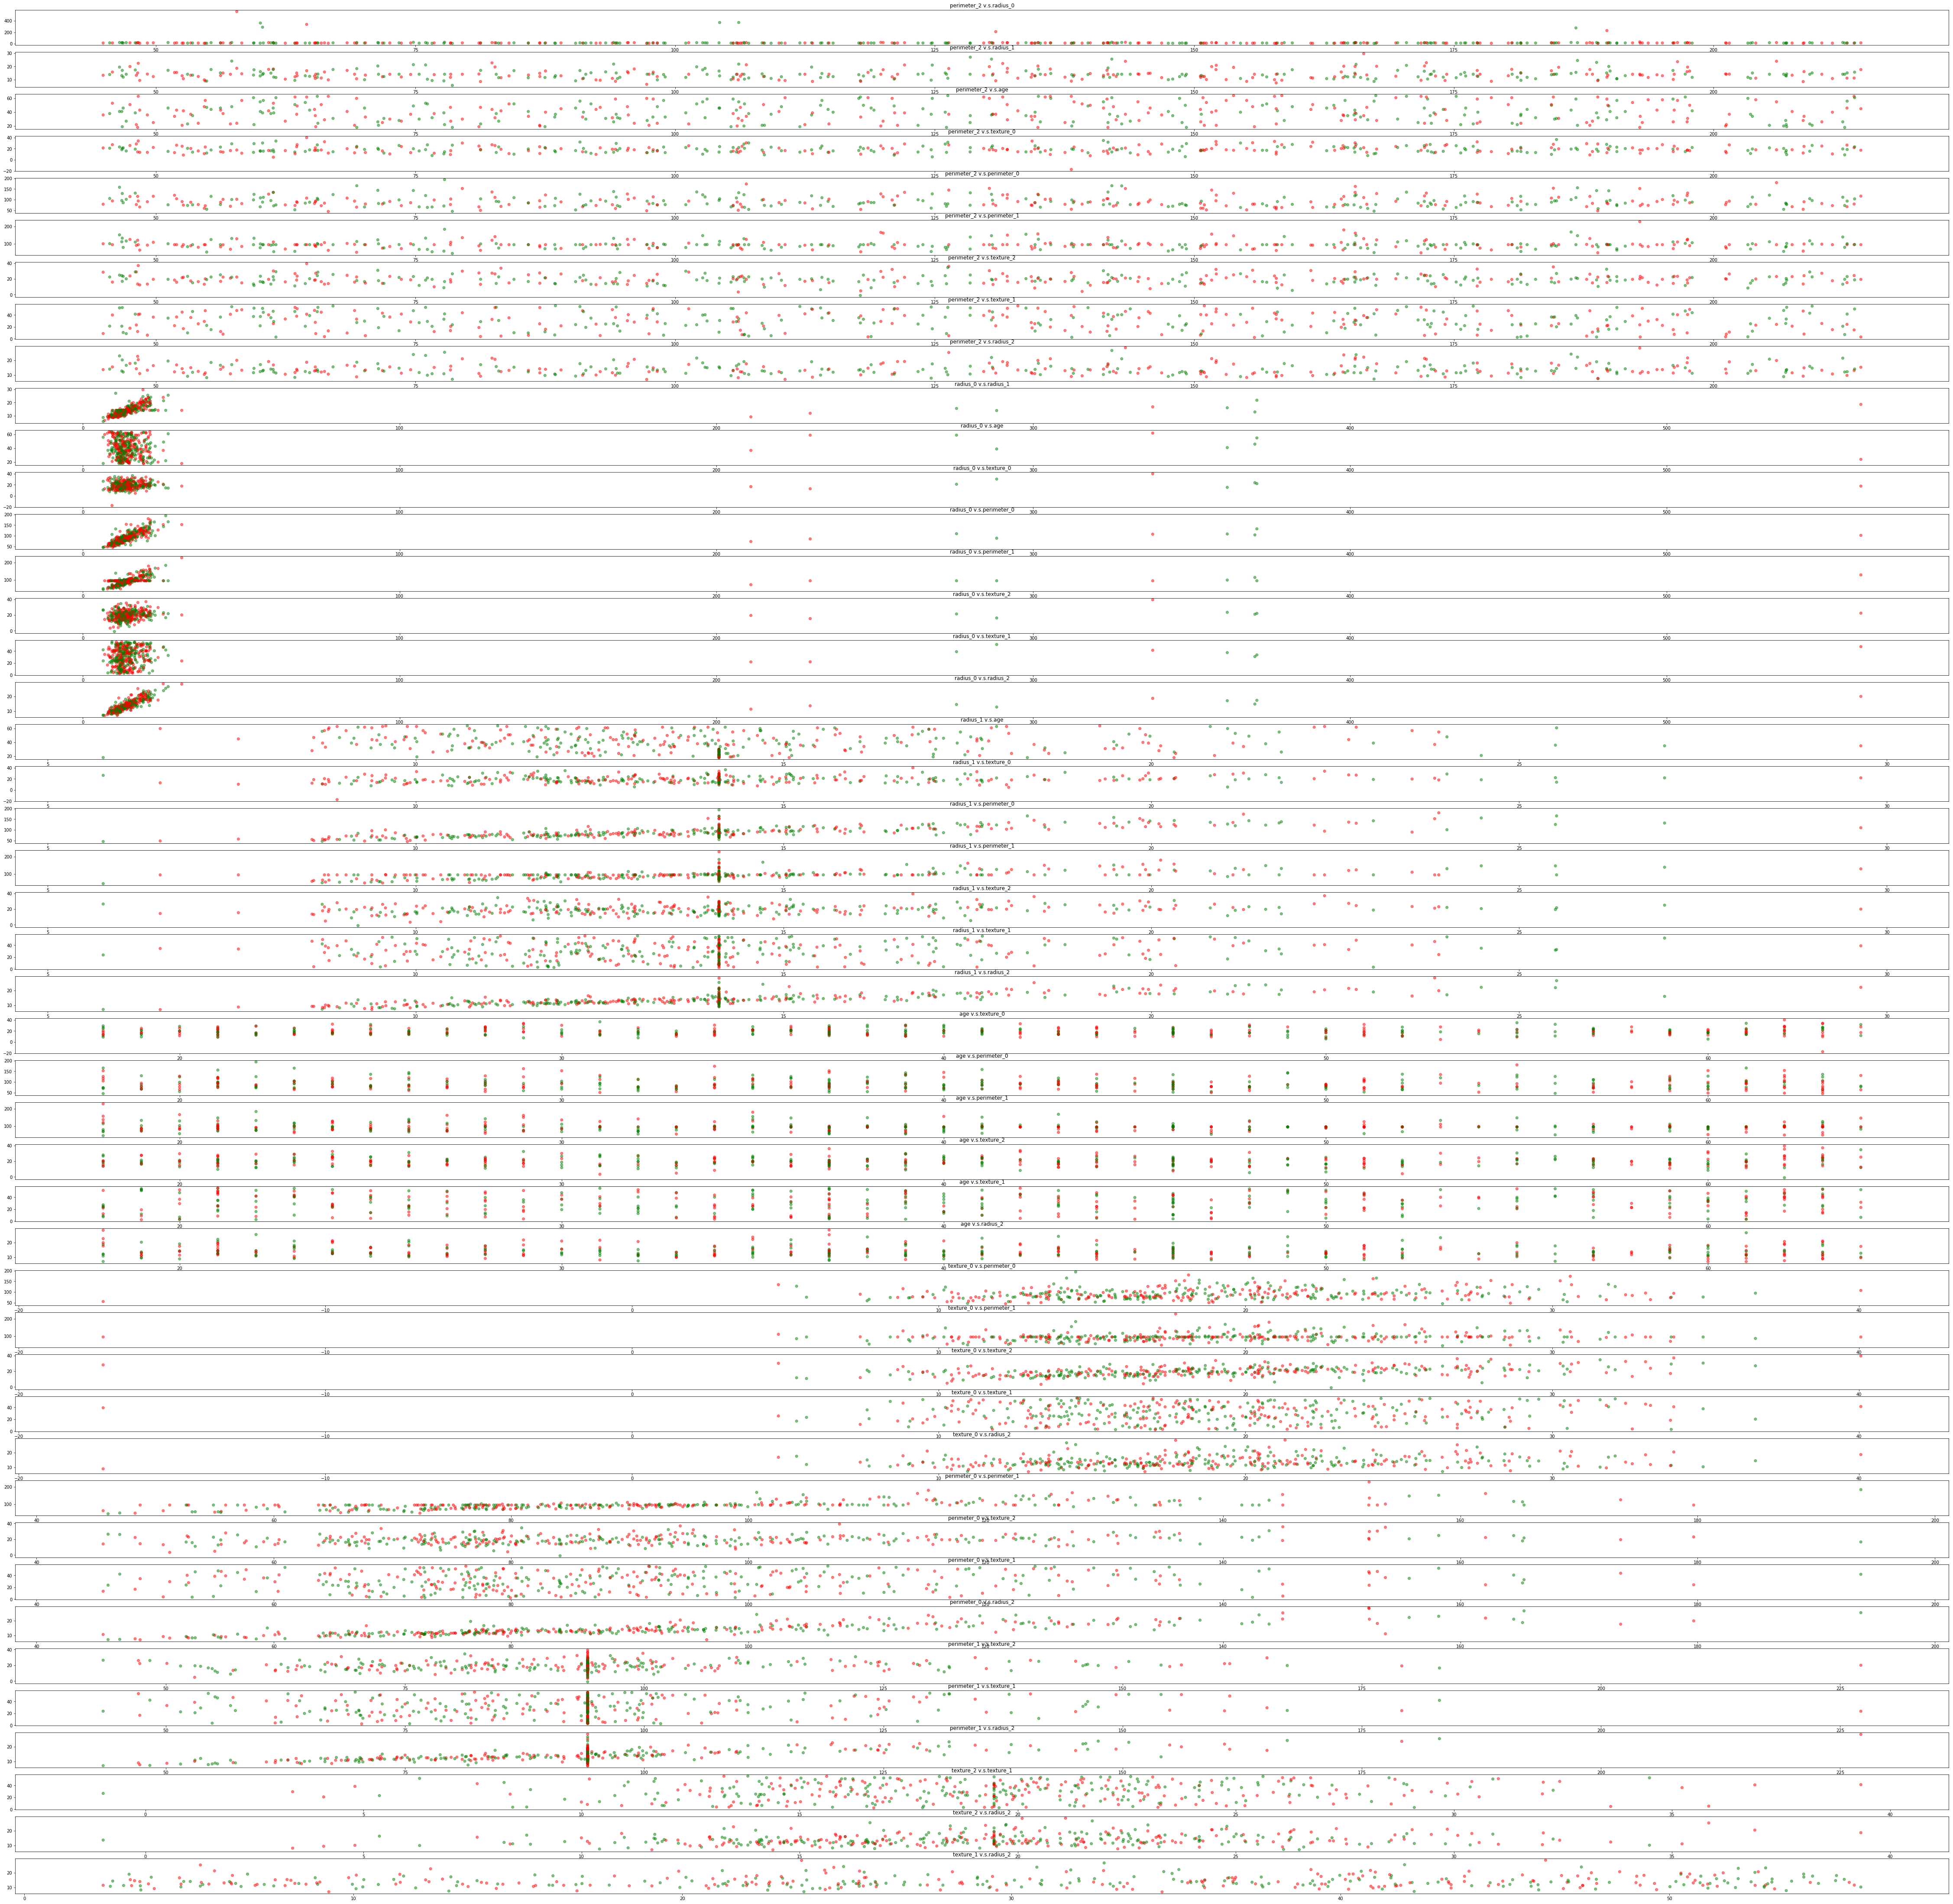

In [27]:
%matplotlib inline
segment = set(train[targetAttribute])
numRows = sum(x for x in range(0, len(numericAttributes)))
#numRows = len(numericAttributes) * len(numericAttributes) -4
fig, ax = plt.subplots(numRows, 1, figsize=(80, 80))
colors = ("red", "green")
k = 0
for i in range(0, len(numericAttributes)):
    for j in range(i, len(numericAttributes)):
        x = numericAttributes[i]
        y = numericAttributes[j]
        if x != y:
            ax[k].scatter(train[x], train[y], alpha=0.5, label=segment, c=colors)
            ax[k].set_title(str(numericAttributes[i])+' v.s.'+ str(numericAttributes[j]))
            k = k + 1
plt.show()

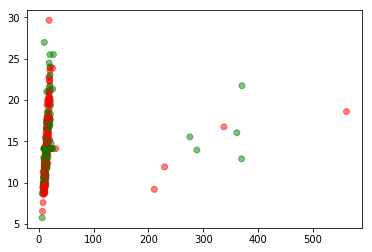

In [32]:
colors = ("red", "green")
plt.scatter(train['radius_0'], train['radius_1'], alpha=0.5, label=segment, c=colors);

           texture_0  texture_1
texture_0   1.000000   0.054536
texture_1   0.054536   1.000000


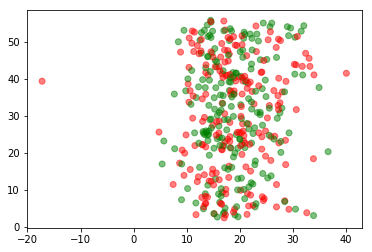

In [39]:
colors = ("red", "green")
print(train[['texture_0','texture_1']].corr(method='pearson'))
plt.scatter(train['texture_0'], train['texture_1'], alpha=0.5, label=segment, c=colors);

Almost no correlation between texture_0 and texture_1

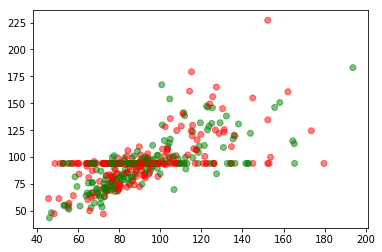

In [37]:
colors = ("red", "green")
plt.scatter(train['perimeter_0'], train['perimeter_1'], alpha=0.5, label=segment, c=colors);

perimeter_0 and perimeter_1 are positve correlation as it can be seen by scatter plot. Missing values of perimeter_1 should have been learned by perimeter_1. I avoided it because of (corr = 0.660504) / high deviation of values after 120 on horizontal axis but should have been tries. 

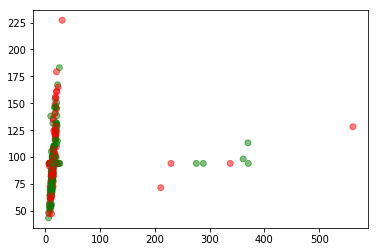

In [35]:
colors = ("red", "green")
plt.scatter(train['radius_0'], train['perimeter_1'], alpha=0.5, label=segment, c=colors);

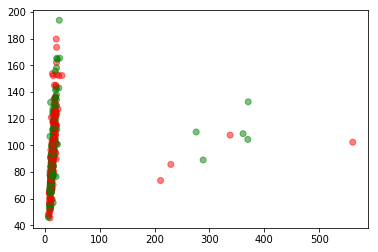

In [34]:
colors = ("red", "green")
plt.scatter(train['radius_0'], train['perimeter_0'], alpha=0.5, label=segment, c=colors);

## Train Correlation Matrix 

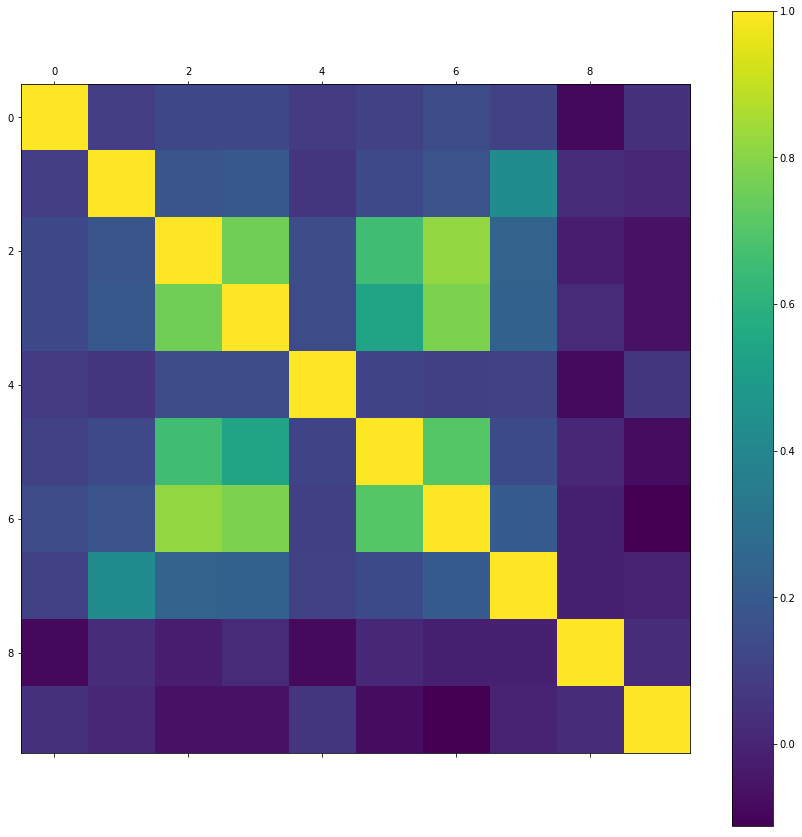

In [40]:
# Only for numeric attributes
fig = plt.figure(1,figsize=(15, 15))
ax = fig.add_subplot(111)
cax = ax.matshow(train.corr())
fig.colorbar(cax)
plt.show()

High correlation between perimter_0/radius_1 and perimter_0/radius_2 and radius_1/radius_2 and radius_2/perimeter_1

In [68]:
train.corr(method='pearson')

,radius_0,texture_0,perimeter_0,radius_1,texture_1,perimeter_1,radius_2,texture_2,perimeter_2,age
radius_0,1.000000,0.090260,0.127806,0.127501,0.081339,0.102342,0.147473,0.101295,-0.088002,0.047784
texture_0,0.090260,1.000000,0.180504,0.193661,0.054536,0.131603,0.171654,0.426034,0.029577,0.015494
perimeter_0,0.127806,0.180504,1.000000,0.757468,0.151266,0.660504,0.820268,0.243558,-0.026881,-0.059903
radius_1,0.127501,0.193661,0.757468,1.000000,0.144733,0.536541,0.782447,0.231772,0.023045,-0.057295
texture_1,0.081339,0.054536,0.151266,0.144733,1.000000,0.112333,0.098114,0.104220,-0.084125,0.055063
perimeter_1,0.102342,0.131603,0.660504,0.536541,0.112333,1.000000,0.708781,0.136152,0.011278,-0.077562
radius_2,0.147473,0.171654,0.820268,0.782447,0.098114,0.708781,1.000000,0.210055,-0.013657,-0.112529
texture_2,0.101295,0.426034,0.243558,0.231772,0.104220,0.136152,0.210055,1.000000,-0.016251,-0.005861
perimeter_2,-0.088002,0.029577,-0.026881,0.023045,-0.084125,0.011278,-0.013657,-0.016251,1.000000,0.030057
age,0.047784,0.015494,-0.059903,-0.057295,0.055063,-0.077562,-0.112529,-0.005861,0.030057,1.000000


## Test Correlation Matrix 

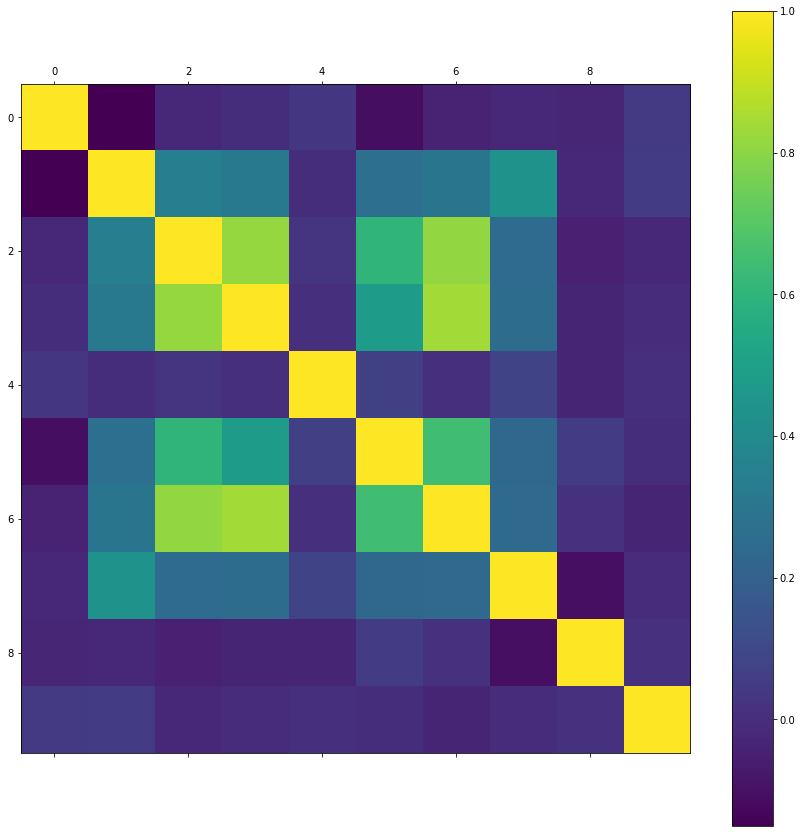

In [71]:
fig = plt.figure(1,figsize=(15, 15))
ax = fig.add_subplot(111)
cax = ax.matshow(test.corr())
fig.colorbar(cax)
plt.show()

In [72]:
test.corr(method='pearson')

,radius_0,texture_0,perimeter_0,radius_1,texture_1,perimeter_1,radius_2,texture_2,perimeter_2,age
radius_0,1.000000,-0.151169,-0.017804,0.000408,0.033183,-0.108061,-0.036623,-0.023622,-0.025641,0.043555
texture_0,-0.151169,1.000000,0.339395,0.315848,-0.000998,0.270029,0.297581,0.439526,-0.018127,0.047276
perimeter_0,-0.017804,0.339395,1.000000,0.817117,0.022073,0.601436,0.814668,0.249697,-0.046733,-0.016829
radius_1,0.000408,0.315848,0.817117,1.000000,0.002985,0.483860,0.841930,0.256182,-0.030003,-0.005523
texture_1,0.033183,-0.000998,0.022073,0.002985,1.000000,0.066462,0.004062,0.083677,-0.031272,0.008230
perimeter_1,-0.108061,0.270029,0.601436,0.483860,0.066462,1.000000,0.646458,0.238704,0.048047,0.000930
radius_2,-0.036623,0.297581,0.814668,0.841930,0.004062,0.646458,1.000000,0.243019,0.014942,-0.031646
texture_2,-0.023622,0.439526,0.249697,0.256182,0.083677,0.238704,0.243019,1.000000,-0.106024,-0.007020
perimeter_2,-0.025641,-0.018127,-0.046733,-0.030003,-0.031272,0.048047,0.014942,-0.106024,1.000000,0.012268
age,0.043555,0.047276,-0.016829,-0.005523,0.008230,0.000930,-0.031646,-0.007020,0.012268,1.000000


# Data Preparation and selection

## Feature Importance

                score
feature              
perimeter_2  0.044401
radius_0     0.073683
radius_1     0.125407
age          0.039768
texture_0    0.063364
perimeter_0  0.252571
perimeter_1  0.118578
texture_2    0.052401
texture_1    0.035892
radius_2     0.193934


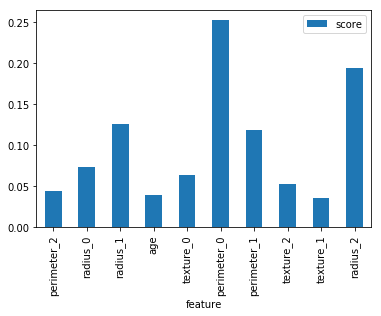

In [42]:
X = train[numericAttributes]
Y = train[targetAttribute].astype(int)
from sklearn.ensemble import ExtraTreesClassifier
# fit an Extra Trees model to the data
model = ExtraTreesClassifier()
model.fit(X, Y.values.ravel())
# display the relative importance of each attribute
df = pd.DataFrame()
df['feature']=numericAttributes
df['score']=list(model.feature_importances_)
df.index = df['feature']
del df['feature']
print(df)
df.plot(kind = 'bar', legend=True, sharex=False);


High correlation between perimter_0/radius_1 and perimter_0/radius_2 and radius_1/radius_2 and radius_2/perimeter_1. 
Most important feature are radius_2, radius_1, radius_0, perimeter_0, perimeter_1. So top features have high correlation.

Score based on split gain etc. 
An extra-trees classifier.
This class implements a meta estimator that fits a number of randomized decision trees (a.k.a. extra-trees) on various sub-samples of the dataset and use averaging to improve the predictive accuracy and control over-fitting.

## Feature Engineering

In [45]:
# Both train and test are cleaned and imputed
train4clf = train.copy()
test4clf = test.copy()

In [46]:
train4clf['treatment_date'] =  train4clf['treatment_date'].astype('datetime64[ns]')
train4clf['diagnose_date'] =  train4clf['diagnose_date'].astype('datetime64[ns]')

# Must include all feature computed
new_features = ['treatment-delay','radius_0_bucket', 'perimeter_0_bucket','perimeter_1_bucket']

# Date difference between treatment and diagnosis
train4clf['treatment-delay'] = abs((train4clf['treatment_date']-train4clf['diagnose_date'])).astype('timedelta64[D]')

# Data discretization for handling outliers
train4clf['radius_0_bucket'] = pd.qcut(train4clf['radius_0'], [0, .25, .5, .75, 1]).cat.codes
train4clf['perimeter_0_bucket'] = pd.qcut(train4clf['perimeter_0'], [0, .25, .5, .75, 1]).cat.codes
train4clf['perimeter_1_bucket'] = pd.qcut(train4clf['perimeter_1'], [0, .25, .5, .75, 1]).cat.codes

# Transform also test data
test4clf['treatment_date'] =  test4clf['treatment_date'].astype('datetime64[ns]')
test4clf['diagnose_date'] =  test4clf['diagnose_date'].astype('datetime64[ns]')
test4clf['treatment-delay'] = abs((test4clf['treatment_date']-test4clf['diagnose_date'])).astype('timedelta64[D]')
test4clf['radius_0_bucket'] = pd.qcut(test4clf['radius_0'], [0, .25, .5, .75, 1]).cat.codes
test4clf['perimeter_0_bucket'] = pd.qcut(test4clf['perimeter_0'], [0, .25, .5, .75, 1]).cat.codes
test4clf['perimeter_1_bucket'] = pd.qcut(test4clf['perimeter_1'], [0, .25, .5, .75, 1],duplicates='drop').cat.codes


train4clf.head(5)

,radius_0,texture_0,perimeter_0,radius_1,texture_1,perimeter_1,radius_2,texture_2,perimeter_2,age,treatment_date,diagnose_date,cancer_type,treatment-delay,radius_0_bucket,perimeter_0_bucket,perimeter_1_bucket
16,12.986264,21.463125,79.254473,13.327439,8.981956,99.308755,13.728816,28.563503,44.918942,36,2000-04-18,2005-03-13,0,1790.0,1,1,3
273,8.454467,7.729734,66.286724,9.394476,21.087932,53.046225,10.946111,19.459098,76.596414,32,2007-02-13,2003-11-20,1,1181.0,0,0,0
197,10.590598,16.687162,69.681129,14.123575,41.344835,67.742404,10.868533,21.002047,57.174787,23,2005-04-16,2003-09-23,1,571.0,0,0,0
204,13.663531,15.282935,82.906412,14.453111,48.176517,88.578308,13.527569,17.337023,97.863396,33,2004-09-15,2003-05-05,1,499.0,2,1,1
106,14.085689,21.359689,91.396123,15.461898,3.349190,94.086379,14.708694,19.239991,118.577848,61,2006-09-15,2007-07-08,0,296.0,2,2,1


df.qcut is Quantile-based discretization function segments values similar to box and whisker plot approach

                       score
feature                     
perimeter_2         0.031156
radius_0            0.035431
radius_1            0.066063
age                 0.025625
texture_0           0.049236
perimeter_0         0.093665
perimeter_1         0.024881
texture_2           0.041364
texture_1           0.031743
radius_2            0.045989
treatment-delay     0.028467
radius_0_bucket     0.282638
perimeter_0_bucket  0.178601
perimeter_1_bucket  0.065141


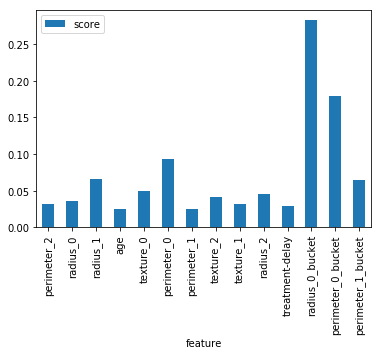

In [47]:
from sklearn.ensemble import ExtraTreesClassifier
X = train4clf[numericAttributes + new_features]
Y = train4clf[targetAttribute].astype(int)
# fit an Extra Trees model to the data
model = ExtraTreesClassifier()
model.fit(X, Y.values.ravel())
# display the relative importance of each attribute
df1 = pd.DataFrame()

df1['feature']=numericAttributes + new_features
df1['score']=list(model.feature_importances_)
df1.index = df1['feature']
del df1['feature']
print(df1)
df1.plot(kind = 'bar', legend=True, sharex=False);
# Without new features, most important feature are 
# radius_2, radius_1, perimeter_0, perimeter_1, radius_0

An extra-trees classifier.
This class implements a meta estimator that fits a number of randomized decision trees (a.k.a. extra-trees) on various sub-samples of the dataset and use averaging to improve the predictive accuracy and control over-fitting.

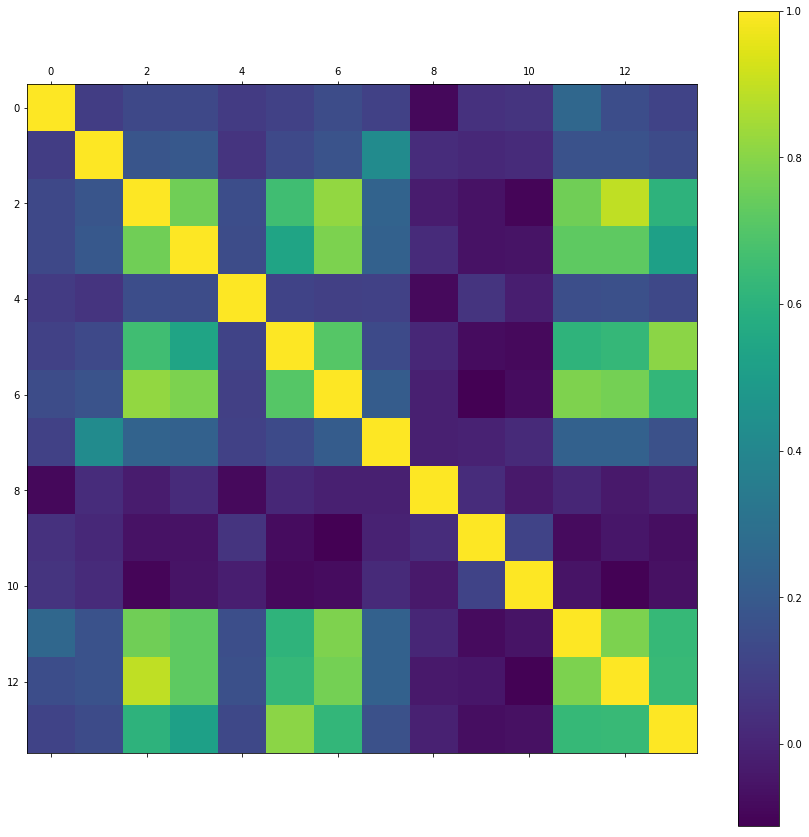

In [77]:
fig = plt.figure(1,figsize=(15, 15))
ax = fig.add_subplot(111)
cax = ax.matshow(train4clf.corr())
fig.colorbar(cax)
plt.show()

In [48]:
train4clf.corr(method='pearson')

,radius_0,texture_0,perimeter_0,radius_1,texture_1,perimeter_1,radius_2,texture_2,perimeter_2,age,treatment-delay,radius_0_bucket,perimeter_0_bucket,perimeter_1_bucket
radius_0,1.000000,0.090260,0.127806,0.127501,0.081339,0.102342,0.147473,0.101295,-0.088002,0.047784,0.053521,0.257753,0.149940,0.110912
texture_0,0.090260,1.000000,0.180504,0.193661,0.054536,0.131603,0.171654,0.426034,0.029577,0.015494,0.024759,0.168319,0.169798,0.143004
perimeter_0,0.127806,0.180504,1.000000,0.757468,0.151266,0.660504,0.820268,0.243558,-0.026881,-0.059903,-0.095541,0.759049,0.891886,0.604563
radius_1,0.127501,0.193661,0.757468,1.000000,0.144733,0.536541,0.782447,0.231772,0.023045,-0.057295,-0.054119,0.722405,0.723403,0.517844
texture_1,0.081339,0.054536,0.151266,0.144733,1.000000,0.112333,0.098114,0.104220,-0.084125,0.055063,-0.020352,0.156299,0.158888,0.128227
perimeter_1,0.102342,0.131603,0.660504,0.536541,0.112333,1.000000,0.708781,0.136152,0.011278,-0.077562,-0.084091,0.611173,0.627340,0.804523
radius_2,0.147473,0.171654,0.820268,0.782447,0.098114,0.708781,1.000000,0.210055,-0.013657,-0.112529,-0.074111,0.786333,0.769489,0.624951
texture_2,0.101295,0.426034,0.243558,0.231772,0.104220,0.136152,0.210055,1.000000,-0.016251,-0.005861,0.018811,0.234601,0.233159,0.163979
perimeter_2,-0.088002,0.029577,-0.026881,0.023045,-0.084125,0.011278,-0.013657,-0.016251,1.000000,0.030057,-0.035906,0.005203,-0.034703,-0.009058
age,0.047784,0.015494,-0.059903,-0.057295,0.055063,-0.077562,-0.112529,-0.005861,0.030057,1.000000,0.112484,-0.079525,-0.043567,-0.069301


Of course hight correlations of buckets with their sources and eventually adopt correlation wiht other variables. 

# Modeling and Parameter Tuning

In [50]:
final_feature_set = numericAttributes + new_features
# final_feature_set = numericAttributes
X = train4clf[final_feature_set]
y = list(train4clf[targetAttribute].values.ravel())
# test data 
test_X = test4clf[final_feature_set]

In [51]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
# n_estimators = trees in the forest
# Empirical good default values are max_features=n_features for regression problems,
# and max_features=sqrt(n_features) for classification tasks
# Good results are often achieved when setting max_depth=None in combination with min_samples_split=2
# Weka best arguments: [-I, 56, -K, 4, -depth, 18]
clf = RandomForestClassifier(n_estimators=50,max_depth=None, max_features=4, bootstrap=True)
# clf = RandomForestClassifier(n_estimators=56,max_depth=18, max_features=4, bootstrap=True)
# clf = RandomForestClassifier(n_estimators=50,max_depth=None, min_samples_split=2, bootstrap=True)
scores = cross_val_score(clf, X, list(y), cv=10, scoring='accuracy')
clf.fit(X, list(y))

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features=4, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

# Model Evaluation

In [53]:
# Overall Data Evaluation
from sklearn.model_selection import cross_val_score
scores = cross_val_score(clf, X, y, cv=10, scoring='accuracy')
# The mean score and the 95% confidence interval of the score estimate are hence given by:

# STD standard deviation of the sample is the degree to which individuals within the sample differ from the sample mean.
# SE standard error of the sample mean is an estimate of how far the sample mean is likely to be from the population mean


# The value of 2 is based on the fact that 95% of the area of a normal distribution is within 2 std 
# 68–95–99.7 rule
# https://en.wikipedia.org/wiki/68%E2%80%9395%E2%80%9399.7_rule

print("Accuracy with 95 confidence interval: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
scores = cross_val_score(clf, X, list(y), cv=10, scoring='precision')
print("Precision with 95 confidence interval: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
scores = cross_val_score(clf, X, list(y), cv=10, scoring='recall')
print("Recall with 95 confidence interval: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
scores = cross_val_score(clf, X, list(y), cv=10, scoring='f1')
print("F1_Measure with 95 confidence interval: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
scores = cross_val_score(clf, X, list(y), cv=10, scoring='roc_auc')
print("ROC_AUC with 95 confidence interval: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy with 95 confidence interval: 0.90 (+/- 0.05)
Precision with 95 confidence interval: 0.90 (+/- 0.09)
Recall with 95 confidence interval: 0.94 (+/- 0.10)
F1_Measure with 95 confidence interval: 0.92 (+/- 0.07)
ROC_AUC with 95 confidence interval: 0.93 (+/- 0.06)


https://en.wikipedia.org/wiki/68–95–99.7_rule

# Test Predictions

In [60]:
predictions = clf.predict(test_X)
submission = pd.DataFrame(predictions)
submission.count()

0    171
dtype: int64

# Export Submission

In [1]:
# submission.to_csv('/submission.csv', index=False, header=False)